# **Building a Distributed Recommender System**

**This iPython notebook is about building a recommender system using Spark, whose computations can be distributed among an arbitrary number of computers so as to make it scalable to any size of data.**

**In this case, I'll be using the small version of the classic [Movielens dataset](http://grouplens.org/datasets/movielens/) with 100,000 ratings, and I'll try different models and compare them by their Root Mean Squared Error (this is the most common metric, and although not the best, it's a good way of trying model parameters in an offline setting, i.e. before doing an actual A/B test of the system in action), dividing the data into sets of training and validation according to the year in which the ratings were made, thus it will be evaluating how accurate are predictions done with data from the past, which is more accurate and representative than a typical random split for cross validation.**

**Then, after identifying a promising model, I'll compute it again using a larger version of the dataset with 10M ratings, leaving out the last year of data, and will compute the RMSE again on the data from the year that was left. I'll also make some predictions by creating a fictional user and inputing my personal ratings for some movies.**

**Such a model-building process (i.e. deciding by what worked best with the year 1998 only) is not optimal, but since I'm limited by my Desktop computer's processing power, this is the only fast way of building a personalized recommender system with Matrix Factorization, which is so far the best family of collaborative filtering algorithms (e.g. vs. user-user based on cosine distance of rating vectors).**

*Note1: in this document, I'll skip the Spark configuration and assume that there is a 'Spark Context' object already created under the name 'sc'.*

*Note2: this small file only has data from the years 1997 and 1998.*


##**Part 1: Loading the data**

In [1]:
import urllib
from zipfile import ZipFile
import datetime
from pyspark.mllib.recommendation import Rating

data_file = urllib.URLopener()
data_file.retrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "ml-100k.zip")
data_file = ZipFile('ml-100k.zip')
data_file.extractall()

def parse_line(line):
    """This function takes as input a line in the format user id | item id | rating | timestamp and
    returns it in converted into a usable format in Spark, keeping only the year form the timestamp"""
    line=line.split()
    return Rating(int(line[0]),int(line[1]),int(line[2])),datetime.datetime.fromtimestamp(int(line[3])).year

#Here I'm reading the data and repartitioning it into 4 workers, as my computer has a CPU with 4 cores.
full_data=sc.textFile(os.getcwd()+'/ml-100k/u.data').repartition(4).map(lambda x: parse_line(x))


#Here I'm splitting the data according to their year, and then I'm discarding the year from it, because it's not a
#predicting factor in the model. The 'year' here refers to the year in which the user made a rating.
train_data=full_data.filter(lambda x: x[1]==1997).map(lambda x: x[0]).cache()
val_data=full_data.filter(lambda x: x[1]==1998).map(lambda x: x[0])

#Viewing a sample observation:
print "Sample Observation:"
print train_data.take(1),'\n'
print "Number of Observations in the training set: ",train_data.count()
print "Number of Observations in the validation set: ",val_data.count()

Sample Observation:
[Rating(user=6, product=86, rating=3.0)] 

Number of Observations in the training set:  52899
Number of Observations in the validation set:  47101


*Note: in the dataset, the movies are encoded by their ID, e.g. with a number rather than their name, but later I'll display some names at the moment of inputing ratings and getting predictions.*


##**Part 2: Creating and building a grid of models**

**In this part, I'll create models based on matrix factorization using alternating least squares and compute their root mean squared error (from now RMSE) on the validation set. I'll try a grid of 24 models using different levels of matrix rank (in other words, latent features in the movie taste space - larger values for this parameter significantly increase computational time, so I'll only try a few low values) and regularization parameters (to avoid overfitting).**

In [2]:
from pyspark.mllib.recommendation import ALS
import numpy as np
import math

def RMSE(predictedRDD, actualRDD):
    """ Compute the root mean squared error between predicted and actual ratings"""
    predictedReformattedRDD = predictedRDD.map(lambda x: ((x[0],x[1]),x[2]))
    actualReformattedRDD = actualRDD.map(lambda x: ((x[0],x[1]),x[2]))
    squaredErrorsRDD = predictedReformattedRDD.join(actualReformattedRDD).map(lambda x: (x[1][0]-x[1][1])**2)
    totalError = squaredErrorsRDD.sum()
    numRatings = squaredErrorsRDD.count()
    return math.sqrt(totalError*1.0/numRatings)
    
rank_grid=[20,40,60,100]
reg_grid=[0.0001,0.01,0.1,0.5]

rnd_seed=100 #This is to make the results reproducible
iters=15 #Larger values crash pySpark

val_data.cache()
val_data_makepreds=val_data.map(lambda x: (x.user,x.product)).cache()

#This list will keep track of which is the best model.
#It will contain: [RMSE, Matrix Rank, Lambda Regularization Parameter, Model Object]
best=[1e10,0,0,None]

#This variable will keep track of the RMSE for different models:
rmse=np.zeros((4,4))
r=-1

for rnk in rank_grid:
    r+=1
    c=-1
    for rg in reg_grid:
        c+=1
        model=ALS.train(train_data,rnk,iterations=iters,lambda_=rg,seed=rnd_seed)
        prd=model.predictAll(val_data_makepreds)
        rmse_model=RMSE(prd,val_data)
        rmse[r,c]=rmse_model
        if rmse_model<best[0]:
            best[0]=rmse_model
            best[1]=rnk
            best[2]=rg
            best[3]=model

print "Best Model Parameters: ",best[1:3]
print "Grid of Errors: "
print rmse.transpose()

Best Model Parameters:  [40, 0.1]
Grid of Errors: 
[[ 2.94252015  2.18227339  1.95783287  1.99008188]
 [ 1.4513158   1.43807011  1.40267643  1.35060612]
 [ 1.06669105  1.05535745  1.05609628  1.05647407]
 [ 1.14611501  1.14612419  1.14612129  1.14612043]]


**As can be seen, it turns out that a moderate range of parameters gave the best result (in this case, rank=40 and lambda=0.1) and the predictions were off by a bit more than 1 star rating in the best model and by almost 3 stars in the worst model.**


##**Part 3: Visualizing the models**

**This grid can also be visualized as a heatmap to see in which direction does the RMSE move according to the choice of parameters:**

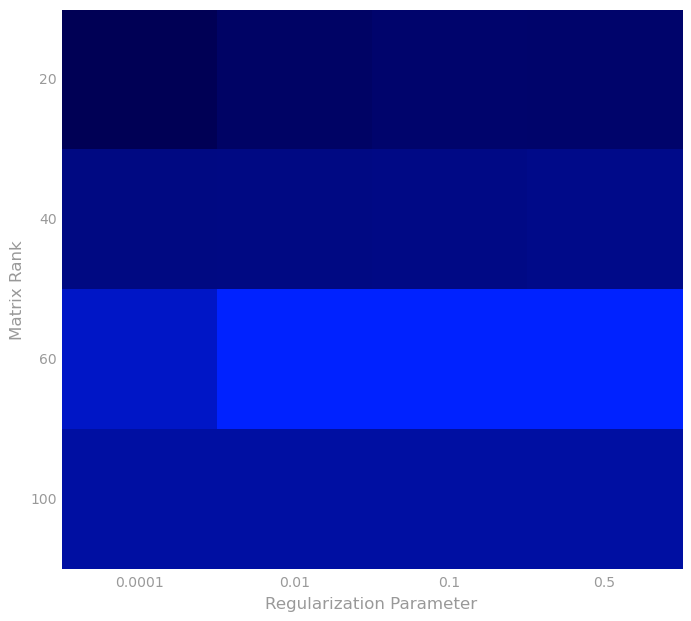

In [12]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

#This function and layout were taken from professor Ameet Talwalkar's lecture exercises on the course CS190.X at Edx Berkeley

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

numRows, numCols = len(rank_grid), len(reg_grid)
rmse = np.array(rmse.transpose())
rmse.shape = (numRows, numCols)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7),
                      hideLabels=True, gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(stepSizes)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Matrix Rank')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(logLoss,interpolation='nearest', aspect='auto',
                    cmap = colors)

**Interpretation: as can be seen, this algorithm tended to overfit the data and larger regularization parameters led to better results. Also, the ideal rank (or latent features) seems to be something in between 40 and 100 - larger values tended to do worse and lower values tended to do significantly worse.**


##**Part 4: Computing the model with a larger dataset**

**Now I'll take the insights gained from this grid search with the small 100k dataset and compute a model with the larger 10M set. Even though the best regularization parameter turned out to be 0.1, I'll now decrease it to 0.05, given that now there is significantly more data and the model won't tend to overfit so much. It would be good to also try different values for the rank (such as 50-60-80), but given the size of this dataset, I'll leave it at only 60 and decrease the number of iterations, as such computations take too much time.**

*Note: this larger version is still not the full dataset (which is over 20M ratings), and it would be interesting to analyze the full model but that would require a cluster of computers, which I don't have.**

In [8]:
data_file = urllib.URLopener()
data_file.retrieve("http://files.grouplens.org/datasets/movielens/ml-10m.zip", "ml-10m.zip")
data_file = ZipFile('ml-10m.zip')
data_file.extractall()

#This time the format is different so I'll need to rewrite this function, and now the ratings come in .5 increases
def parse_line(line):
    """This function takes as input a line in the format user id::item_id::rating::timestamp and
    returns it in converted into a usable format in Spark, keeping only the year form the timestamp"""
    line=line.split('::')
    return Rating(int(line[0]),int(line[1]),float(line[2])),datetime.datetime.fromtimestamp(float(line[3])).year

full_data=sc.textFile(os.getcwd()+'/ml-10M100K/ratings.dat').repartition(4).map(lambda x: parse_line(x))

train_data=full_data.filter(lambda x: x[1]!=2003 and x[1]!=2002).map(lambda x: x[0])
test_data=full_data.filter(lambda x: x[1]==2003 or x[1]==2002).map(lambda x: x[0])
model=ALS.train(train_data,rank=60,iterations=5,lambda_=0.05,seed=100)

##**Part 5: Computing the test-set RMSE**

In [20]:
prd=model.predictAll(test_data.map(lambda x: (x.user,x.product)))
rmse=RMSE(prd,test_data)
print 'RMSE is now: ',rmse

RMSE is now:  0.917741371815


###Interpretation:

The RMSE is in the same units as the ratings itself. Thus, we can conclude that this model made predictions that were off, on average, by around 1 star in a 1-5 scale, which is a better result than with the smaller dataset.

##**Part 6: Computing summary statistics**

**It would also be interesting to see some summary statistics in this dataset. Here I'll compute the 20 highest rated movies (considering only those with more than 100 ratings), and the 20 most frequently rated movies.**

In [39]:
def parse_movie_line(line):
    """Parses a line in the movie info data and returns a tuple (MovieID, Title)"""
    line=line.split('::')
    return line[0],line[1]

movie_names=sc.textFile(os.getcwd()+'/ml-10M100K/movies.dat').repartition(4).map(lambda x: parse_movie_line(x))

def counts_and_rating(IDandRatingsTuple):
    """ Calculate average rating
    Args:
        IDandRatingsTuple: a single tuple of (MovieID, (Rating1, Rating2, Rating3, ...))
    Returns:
        tuple: a tuple of (MovieID, (number of ratings, averageRating))
    """
    temp=len(IDandRatingsTuple[1])
    return (IDandRatingsTuple[0],(temp,sum(IDandRatingsTuple[1])*1.0/temp))
   
data_stats=full_data.map(lambda x: (x[0].product,x[0].rating)).groupByKey().map(lambda x: counts_and_rating(x))
highest_rated=data_stats.filter(lambda x: x[1][0]>100).map(lambda x: (x[0],x[1][1])).takeOrdered(20,lambda x: -x[1])
highest_rated=sc.parallelize(highest_rated)
highest_rated=highest_rated.join(movie_names).map(lambda x: (x[1][1],x[1][0])).takeOrdered(20,lambda x: -x[1])

most_rated=data_stats.map(lambda x: (x[0],x[1][0])).takeOrdered(20,lambda x: -x[1])
most_rated=sc.parallelize(most_rated)
most_rated=most_rated.join(movie_names).map(lambda x: (x[1][1],x[1][0])).takeOrdered(20,lambda x: -x[1])

print "Highest Rated Movies:"
for line in highest_rated:
    print line
print '\n'
print "Most Rated Movies: "
for line in most_rated:
    print line

Highest Rated Movies:
(u'Shawshank Redemption, The (1994)', 4.457238321660348)
(u'Godfather, The (1972)', 4.415085293227011)
(u'Usual Suspects, The (1995)', 4.367142322253193)
(u"Schindler's List (1993)", 4.363482949916592)
(u'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)', 4.321966205837174)
(u'Casablanca (1942)', 4.319740945070761)
(u'Rear Window (1954)', 4.316543909348442)
(u'Double Indemnity (1944)', 4.315439034540158)
(u'Seven Samurai (Shichinin no samurai) (1954)', 4.314119283602851)
(u'Third Man, The (1949)', 4.313629402756509)
(u'Paths of Glory (1957)', 4.306805399325085)
(u'Godfather: Part II, The (1974)', 4.303215119343423)
(u'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 4.298072023101749)
(u'Lives of Others, The (Das Leben der Anderen) (2006)', 4.297154471544715)
(u'Dark Knight, The (2008)', 4.294842186297152)
(u"One Flew Over the Cuckoo's Nest (1975)", 4.292379632836855)
(u'Yojimbo (1961)', 4.277613703484938)
(u'Wallace & Gromit: The Wrong T

*Note: the dataset encompasses the ratings from 1997 up to February of 2003, that's why we see mostly movies from the late 1990s.*

##**Part 7: Computing predictions for a new user**

**In this part, I'll create a new user and rate some movies myself to see which are the top 20 recommended movies for me based on these ratings. First, I'll print a list of the 50 most rated movies and their IDs and then I'll enter my ratings for the movies in that list that I've seen, trying to exclude some overly popular ones so as no let the sysyem make better predictions:**

In [38]:
most_rated=data_stats.map(lambda x: (x[0],x[1][0])).takeOrdered(50,lambda x: -x[1])
most_rated=sc.parallelize(most_rated)
most_rated=most_rated.join(movie_names).map(lambda x: (x[1][1],x[0])).collect()
for line in most_rated:
    print line

(u'Ace Ventura: Pet Detective (1994)', u'344')
(u'Toy Story (1995)', u'1')
(u'Back to the Future (1985)', u'1270')
(u'Pulp Fiction (1994)', u'296')
(u'True Lies (1994)', u'380')
(u'American Beauty (1999)', u'2858')
(u'Dances with Wolves (1990)', u'590')
(u'Ghost (1990)', u'587')
(u'12 Monkeys (Twelve Monkeys) (1995)', u'32')
(u'Terminator, The (1984)', u'1240')
(u'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', u'1198')
(u'Seven (a.k.a. Se7en) (1995)', u'47')
(u'Sixth Sense, The (1999)', u'2762')
(u'Mask, The (1994)', u'367')
(u'Mission: Impossible (1996)', u'648')
(u'Forrest Gump (1994)', u'356')
(u'Die Hard: With a Vengeance (1995)', u'165')
(u'Apollo 13 (1995)', u'150')
(u'Silence of the Lambs, The (1991)', u'593')
(u'Batman Forever (1995)', u'153')
(u'Lion King, The (1994)', u'364')
(u'Men in Black (1997)', u'1580')
(u'Rock, The (1996)', u'733')
(u'Star Wars: Episode VI - Return of the Jedi (1983)', u'1210')
(u'Batman (1989)', u'592')
(u"Schindler's

*Note: unlike in the previous output, these are now show with their movie ID rather than with the count of ratings and are not ordered.*

**Now I'll input my ratings for some of these movies as user 0:**

In [66]:
my_ratings_list=[Rating(0,1270, 3),
Rating(0,296, 1),
Rating(0,2858, 5),
Rating(0,32, 4.5),
Rating(0,1240, 4.5),
Rating(0,1198, 1),
Rating(0,47, 4.5),
Rating(0,2762, 4),
Rating(0,648, 2.5),
Rating(0,367, 2.5),
Rating(0,648, 2),
Rating(0,356, 5),
Rating(0,165, 4),
Rating(0,593, 2),
Rating(0,153, 1.5),
Rating(0,1580, 3.5),
Rating(0,527, 2),
Rating(0,318, 5),
Rating(0,1097,5),
Rating(0,260, 4.5),
Rating(0,858, 5),
Rating(0,2028, 1),
Rating(0,780, 3.5),
Rating(0,231, 4),
Rating(0,316, 3.5),
Rating(0,110, 4.5),
Rating(0,50, 5),
Rating(0,608, 3.5),
Rating(0,589, 4.5),
Rating(0,2571, 4)]
my_ratings=sc.parallelize(my_ratings_list)
training_with_mine=train_data.union(my_ratings)
model=ALS.train(training_with_mine,rank=60,iterations=5,lambda_=0.05,seed=100)

movies_to_predict = full_data.map(lambda x: int(x[0].product)).distinct().filter(lambda x: x not in [rat.product for rat in my_ratings_list]).map(lambda x: (0,x))
predicted_for_me = model.predictAll(movies_to_predict).takeOrdered(30,lambda x: -x.rating)
predicted_for_me=sc.parallelize(predicted_for_me)
predicted_for_me=predicted_for_me.map(lambda x: (str(x.product),x.rating)).join(movie_names).map(lambda x: (x[1][1],x[1][0])).takeOrdered(30, lambda x: -x[1])

print "Top 30 Predicted Movies for me:"
for line in predicted_for_me:
    print line

Top 30 Predicted Movies for me:
(u'Love & Sex (2000)', 5.007908621690618)
(u'Sacco and Vanzetti (Sacco e Vanzetti) (1971)', 4.612573317410383)
(u'Fast Food, Fast Women (2000)', 4.4466806766184375)
(u'Baran (2001)', 4.4016901232483265)
(u'Forbidden Games (Jeux interdits) (1952)', 4.366745220543698)
(u'For the Bible Tells Me So (2007)', 4.293391032114822)
(u'Low Life, The (1995)', 4.226921246180655)
(u'Passion in the Desert (1998)', 4.205198165390448)
(u'Life of Oharu, The (Saikaku ichidai onna) (1952)', 4.173846276253784)
(u'Beefcake (1999)', 4.1703938945816486)
(u'Barenaked in America (1999)', 4.154299479843564)
(u'Saint of Fort Washington, The (1993)', 4.136695689609327)
(u'FLCL (2000)', 4.118294303984808)
(u'Hail Columbia! (1982)', 4.110041445026499)
(u'Shadows of Forgotten Ancestors (1964)', 4.106222317578341)
(u'Mindwalk (1990)', 4.105007359653488)
(u"Antonia's Line (Antonia) (1995)", 4.069697679298748)
(u'Eddie Murphy Raw (1987)', 4.053866658103439)
(u"That's The Way I Like It (a.

**Unfortunately, I cannot comment much from the ouput above because I haven't seen any of those movies, with the exception of 'Fight Club' which I would have rated a 5. However, it wouldn't be appropriate to judge the quality of such recommendations when the system had such few ratings on my part and only for overly popular movies.**